In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from os import listdir
import pickle

In [4]:
# Data location
DATA_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_2/data'
RESULTS_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_2/results'
TRANSITION_RESULTS_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_2/results/transition-influence'

# Model info
MODELS = ['ss', 'ss-sampler', 'ff']
N_PARAM_BINS = 5

# Aesthetics
MODEL_COLORS = {
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}

# Functions

## Helper Functions

In [22]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def get_frequent_targets(df):
    """
    Get frequent targets from a DataFrame

    Arguments
    ---------
    df : pd.DataFrame
        Choice phase data
    
    Returns
    -------
    None
    """
    df['freq'] = 0
    idx = (
        (df['target'] == '[1 4 0 0]') |
        (df['target'] == '[4 1 0 0]') |
        (df['target'] == '[0 0 1 4]') |
        (df['target'] == '[0 0 4 1]') 
    )
    df.loc[idx, 'freq'] = 1

def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            round(x.left, n),
            round(x.right, n)
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned

## Plot Functions

In [6]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            ci = None
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        max_reward = np.max(df['reward'])
        chance = max_reward/2
    elif y == 'p':
        chance = .25
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.set_ylim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)

# Load Data

## Training

In [7]:
# Load training data
training_df = []
for model in MODELS:
    training_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/training'))
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)

# Label blocks
n_training_trials = np.max(training_df['trial'])
training_df['block'] = (training_df['trial'] > n_training_trials/2) + 1

# Label frequent targets
get_frequent_targets(training_df)

training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,...,options_comb,target,options,composition,successor,p,reward,correct,block,freq
0,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.250000,1,0,1,1
1,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.250000,1,0,1,1
2,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 3 0 0],[1 4 0 0],0.250000,2,1,1,1
3,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.198180,1,0,1,1
4,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.301820,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439995,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.999265,2,1,2,1
1439996,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 1 4],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.998892,2,1,2,1
1439997,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.999656,2,1,2,1
1439998,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 1 4],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.999446,2,1,2,1


## Test

In [8]:
test_df = []
for model in MODELS:
    test_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/test'))
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,...,trial,target_comb,options_comb,target,options,composition,successor,p,reward,correct
0,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,2,[0 0 1 1],[1 1 0 0],[0 0 1 1],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.25,0,0
1,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,3,[0 0 1 1],[1 0 1 0],[0 0 1 1],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 0 2 0]\n [0...,[3 0 3 0],[4 0 4 0],0.25,0,0
2,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,4,[0 0 1 1],[1 0 0 1],[0 0 1 1],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 0 0 2]\n [0...,[2 0 0 3],[1 0 0 4],0.25,0,0
3,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,5,[0 0 1 1],[0 1 1 0],[0 0 1 1],[[[0 2 0 0]\n [0 3 0 0]]\n\n [[0 0 2 0]\n [0...,[0 3 3 0],[0 4 4 0],0.25,0,0
4,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,6,[0 0 1 1],[0 1 0 1],[0 0 1 1],[[[0 2 0 0]\n [0 3 0 0]]\n\n [[0 0 0 2]\n [0...,[0 3 0 3],[0 4 0 4],0.25,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431995,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,141,[1 1 0 0],[1 0 1 0],[4 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 0 2 0]\n [0...,[3 0 3 0],[4 0 4 0],0.50,1,0
431996,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,142,[1 1 0 0],[1 0 0 1],[4 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 0 0 2]\n [0...,[3 0 0 2],[4 0 0 1],0.50,1,0
431997,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,143,[1 1 0 0],[0 1 1 0],[4 4 0 0],[[[0 2 0 0]\n [0 3 0 0]]\n\n [[0 0 2 0]\n [0...,[0 3 2 0],[0 4 1 0],0.50,1,0
431998,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,144,[1 1 0 0],[0 1 0 1],[4 4 0 0],[[[0 2 0 0]\n [0 3 0 0]]\n\n [[0 0 0 2]\n [0...,[0 3 0 2],[0 4 0 1],0.50,1,0


## Representations

In [9]:
representations = {}
for model in MODELS:
    for fname in listdir(f'{DATA_PATH}/{model}/representations'):
        if fname.startswith('.'):
            continue
        agent_id = int(fname.split('_')[1].replace('.pkl', ''))
        with open(f'{DATA_PATH}/{model}/representations/{fname}', 'rb') as f:
            representations[agent_id] = standardize_reps_order(pickle.load(f))

## Subject Information 

In [10]:
subj_df = test_df[['id', 'model_label', 'alpha', 'beta', 'segmentation']]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df

,id,model_label,alpha,beta,segmentation
0,1119,ss,0.604867,2.632592,1.000000
1,1131,ss,0.342060,1.602646,1.000000
2,1657,ss,0.289936,8.911278,1.000000
3,1643,ss,0.336130,1.243376,1.000000
4,1125,ss,0.975370,42.883080,1.000000
...,...,...,...,...,...
2995,161,ff,0.984755,0.555725,0.111002
2996,607,ff,0.113624,0.885448,0.194875
2997,613,ff,0.937780,1.169767,0.115368
2998,175,ff,0.390268,2.080072,0.287564


## Transition Influence

In [13]:
trans_influence_df = []
for fname in listdir(TRANSITION_RESULTS_PATH):
    if fname.startswith('.'):
        continue
    
    # Get agent ID from file name
    agent_id = int(fname.replace('.pkl', '').split('_')[1])

    # Load trace
    with open(f'{TRANSITION_RESULTS_PATH}/{fname}', 'rb') as f:
        trace = pickle.load(f)

    # Extract coefficients
    coefs = az.summary(trace)['mean'].values
    coefs = coefs.reshape(-1, 2)
    
    try:
        # Add to full results set
        coefs_df = pd.DataFrame({
            'id': agent_id,
            'action': [1, 2, 3],
            'incidental': coefs[:, 0],
            'true': coefs[:, 1]
        })
        trans_influence_df.append(coefs_df)

    except:

        print(f'ISSUE WITH AGENT {agent_id} COEFS')

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information
trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = 'id'
)

trans_influence_df

ISSUE WITH AGENT 568 COEFS
ISSUE WITH AGENT 2226 COEFS


,id,action,transition,coef,model_label,alpha,beta,segmentation
0,1450,1,incidental,0.009,ss,0.521198,0.082099,1.0
1,1450,2,incidental,-0.092,ss,0.521198,0.082099,1.0
2,1450,3,incidental,-0.014,ss,0.521198,0.082099,1.0
3,1450,1,true,1.483,ss,0.521198,0.082099,1.0
4,1450,2,true,1.172,ss,0.521198,0.082099,1.0
...,...,...,...,...,...,...,...,...
13855,1449,2,incidental,0.825,ss,0.760579,0.172650,1.0
13856,1449,3,incidental,0.369,ss,0.760579,0.172650,1.0
13857,1449,1,true,3.899,ss,0.760579,0.172650,1.0
13858,1449,2,true,4.419,ss,0.760579,0.172650,1.0


# Training Analysis

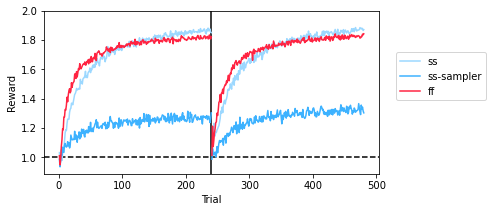

In [21]:
plot_training_curve(
    training_df,
    'reward',
    'model_label',
    palette = MODEL_COLORS
)

## Feature-Based Model

In [23]:
# Get feature-based model data
idx = training_df['model_label'] == 'ff'
ff_training_df = training_df.loc[idx]
ff_training_df = ff_training_df.reset_index(drop=True)

# Check if alpha_decay was simulated
plot_alpha_decay = len(np.unique(ff_training_df['alpha_decay'])) > 1

# Bin parameters
ff_training_df['alpha_bin'] = bin_params(
    ff_training_df['alpha'],
    N_PARAM_BINS
)
if plot_alpha_decay:
    ff_training_df['alpha_decay_bin'] = bin_params(
        ff_training_df['alpha_decay'],
        N_PARAM_BINS,
        method = pd.qcut
    )
ff_training_df['beta_bin'] = bin_params(
    ff_training_df['beta'],
    N_PARAM_BINS,
    method = pd.qcut
)
ff_training_df['segmentation_bin'] = bin_params(
    ff_training_df['segmentation'],
    N_PARAM_BINS
)

### Learning Rate

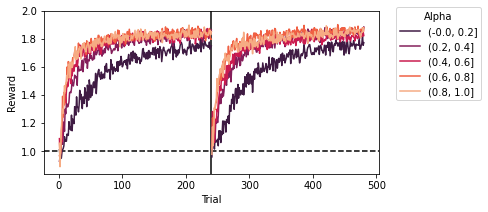

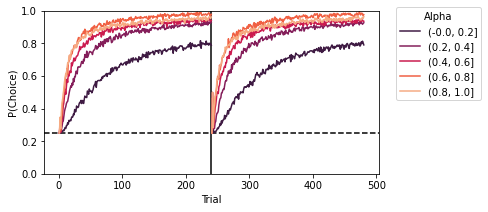

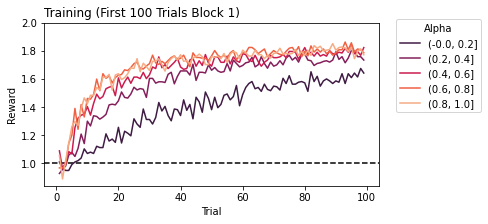

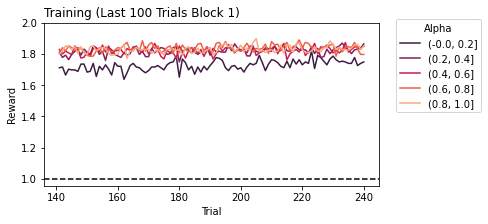

In [24]:
plot_training_curve(
    ff_training_df,
    'reward',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha'
)

plot_training_curve(
    ff_training_df,
    'p',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha'
)

plot_training_curve(
    ff_training_df.loc[ff_training_df['trial'] < 100],
    'reward',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha',
    title = 'Training (First 100 Trials Block 1)'
)

idx = (
    (ff_training_df['trial'] > (n_training_trials/2 - 100)) &
    (ff_training_df['block'] == 1)
)
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'alpha_bin',
    palette = 'rocket',
    legend_title = 'Alpha',
    title = 'Training (Last 100 Trials Block 1)'
)

### Learning Rate Decay

In [27]:
if plot_alpha_decay:
    
    plot_training_curve(
        ff_training_df,
        'reward',
        'alpha_decay_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay'
    )

    plot_training_curve(
        ff_training_df,
        'p',
        'alpha_decay_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay'
    )

    plot_training_curve(
        ff_training_df.loc[ff_training_df['trial'] < 100],
        'reward',
        'alpha_decay_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay',
        title = 'Training (First 100 Trials Block 1)'
    )

    idx = (
        (ff_training_df['trial'] > (n_training_trials/2 - 100)) &
        (ff_training_df['block'] == 1)
    )
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'alpha_bin',
        palette = 'rocket',
        legend_title = 'Alpha Decay',
        title = 'Training (Last 100 Trials Block 1)'
    )

    idx = ff_training_df['alpha_decay'] < .2
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'alpha_bin',
        palette = 'rocket',
        legend_title = 'Alpha',
        title = 'Training (Alpha Decay < .2)'
    )

    idx = ff_training_df['alpha_decay'] > .8
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'alpha_bin',
        palette = 'rocket',
        legend_title = 'Alpha',
        title = 'Training (Alpha Decay > .8)'
    )

    plot_param_interaction(
        ff_training_df.loc[ff_training_df['block'] == 1],
        'alpha',
        'alpha_decay_bin',
        'reward',
        title = 'Training (Block 1)',
        legend_title = 'Alpha Decay',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
    )

    plot_param_interaction(
        ff_training_df.loc[ff_training_df['block'] == 2],
        'alpha',
        'alpha_decay_bin',
        'reward',
        title = 'Training (Block 2)',
        legend_title = 'Alpha Decay',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
    )

    plot_param_interaction(
        ff_training_df,
        'alpha',
        'alpha_decay_bin',
        'p',
        title = 'Training',
        legend_title = 'Alpha Decay',
        xlabel = 'Alpha',
        ylabel = 'P(Choice)',
        palette = 'rocket'
    )

### Inverse Temperature

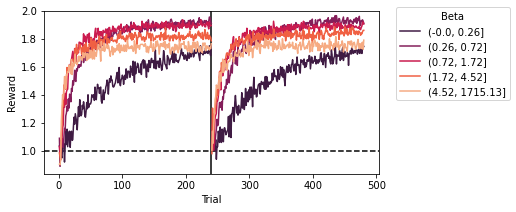

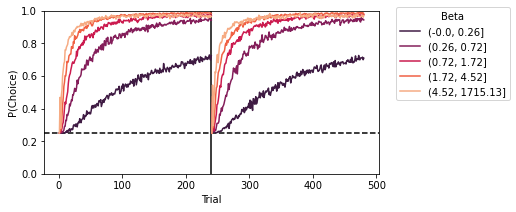

In [28]:
plot_training_curve(
    ff_training_df,
    'reward',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta'
)

plot_training_curve(
    ff_training_df,
    'p',
    'beta_bin',
    palette = 'rocket',
    legend_title = 'Beta'
)

### Segmentation

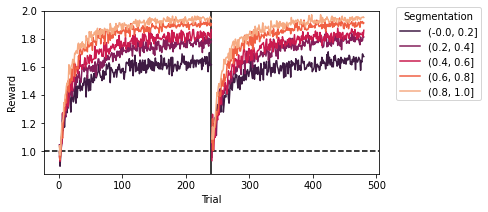

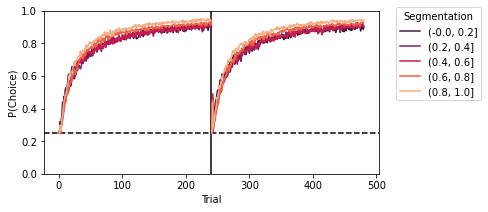

In [29]:
plot_training_curve(
    ff_training_df,
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation'
)

plot_training_curve(
    ff_training_df,
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation'
)

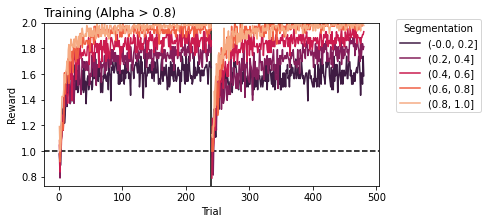

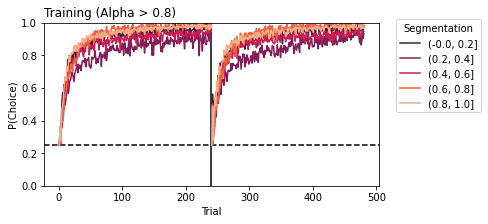

In [30]:
idx = ff_training_df['alpha'] > .8
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha > 0.8)'
)

plot_training_curve(
    ff_training_df.loc[idx],
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha > 0.8)'
)

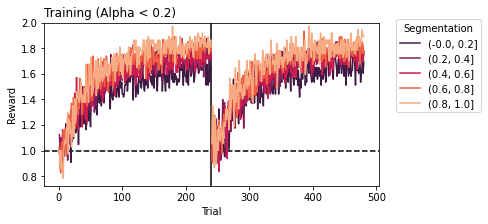

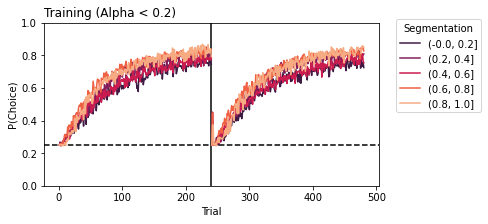

In [31]:
idx = ff_training_df['alpha'] < .2
plot_training_curve(
    ff_training_df.loc[idx],
    'reward',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha < 0.2)'
)

plot_training_curve(
    ff_training_df.loc[idx],
    'p',
    'segmentation_bin',
    palette = 'rocket',
    legend_title = 'Segmentation',
    title = 'Training (Alpha < 0.2)'
)

In [32]:
if plot_alpha_decay:
    
    idx = ff_training_df['alpha_decay'] > .8
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'segmentation_bin',
        palette = 'rocket',
        legend_title = 'Segmentation',
        title = 'Training (Alpha Decay > 0.8)'
    )

    idx = ff_training_df['alpha_decay'] < .2
    plot_training_curve(
        ff_training_df.loc[idx],
        'reward',
        'segmentation_bin',
        palette = 'rocket',
        legend_title = 'Segmentation',
        title = 'Training (Alpha Decay < 0.2)'
    )

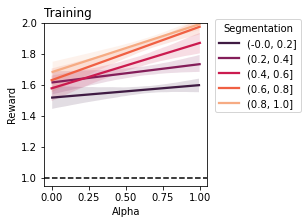

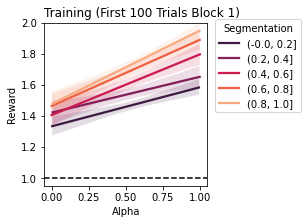

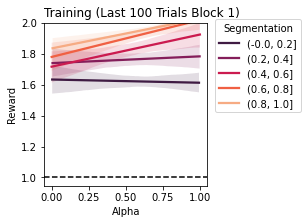

In [33]:
plot_param_interaction(
        ff_training_df,
        'alpha',
        'segmentation_bin',
        'reward',
        title = 'Training',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
)

plot_param_interaction(
        ff_training_df.loc[ff_training_df['trial'] < 100],
        'alpha',
        'segmentation_bin',
        'reward',
        title = 'Training (First 100 Trials Block 1)',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
)

idx = (
    (ff_training_df['trial'] > (n_training_trials/2 - 100)) &
    (ff_training_df['block'] == 1)
)
plot_param_interaction(
        ff_training_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'reward',
        title = 'Training (Last 100 Trials Block 1)',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Reward',
        palette = 'rocket'
)

### Transition Influence

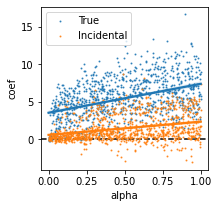

In [35]:
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='black', linestyle='--', zorder=0)

idx = plot_df['transition'] == 'true'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'True',
    ax = ax
)

idx = plot_df['transition'] == 'incidental'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'Incidental',
    ax = ax
)

ax.legend()

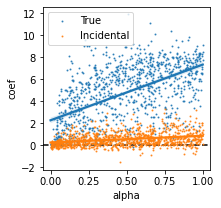

In [36]:
idx = trans_influence_df['model_label'] == 'ss'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='black', linestyle='--', zorder=0)

idx = plot_df['transition'] == 'true'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'True',
    ax = ax
)

idx = plot_df['transition'] == 'incidental'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'Incidental',
    ax = ax
)

ax.legend()

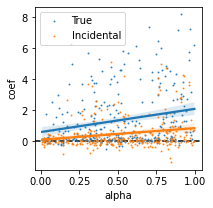

In [41]:
idx = trans_influence_df['model_label'] == 'ss-sampler'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'alpha',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'alpha',
    'transition'
])
plot_df = plot_df.mean().reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='black', linestyle='--', zorder=0)

idx = plot_df['transition'] == 'true'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'True',
    ax = ax
)

idx = plot_df['transition'] == 'incidental'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'alpha',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'Incidental',
    ax = ax
)

ax.legend()

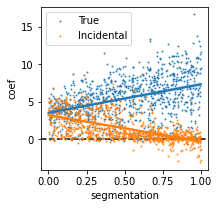

In [40]:
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx, [
    'id',
    'segmentation',
    'transition',
    'coef'
]]
plot_df = plot_df.groupby([
    'id',
    'segmentation',
    'transition'
])
plot_df = plot_df.mean().reset_index()

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='black', linestyle='--', zorder=0)

idx = plot_df['transition'] == 'true'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'segmentation',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'True',
    ax = ax
)

idx = plot_df['transition'] == 'incidental'
sns.regplot(
    data = plot_df.loc[idx],
    x = 'segmentation',
    y = 'coef',
    scatter_kws = {'s': 1},
    label = 'Incidental',
    ax = ax
)

ax.legend()

/var/folders/6r/9ld8dfs177vc74rlqc8h2m_m0000gn/T/ipykernel_63344/4173936989.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['segmentation_bin'] = bin_params(


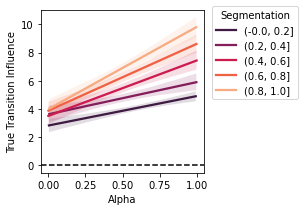

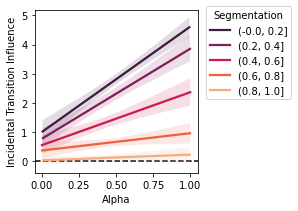

In [43]:
idx = trans_influence_df['model_label'] == 'ff'
plot_df = trans_influence_df.loc[idx]
plot_df['segmentation_bin'] = bin_params(
        plot_df['segmentation'],
        N_PARAM_BINS
)

idx = plot_df['transition'] == 'true'
plot_param_interaction(
        plot_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'True Transition Influence',
        palette = 'rocket'
)

idx = plot_df['transition'] == 'incidental'
plot_param_interaction(
        plot_df.loc[idx],
        'alpha',
        'segmentation_bin',
        'coef',
        legend_title = 'Segmentation',
        xlabel = 'Alpha',
        ylabel = 'Incidental Transition Influence',
        palette = 'rocket'
)

# Representations

124.96792194529971

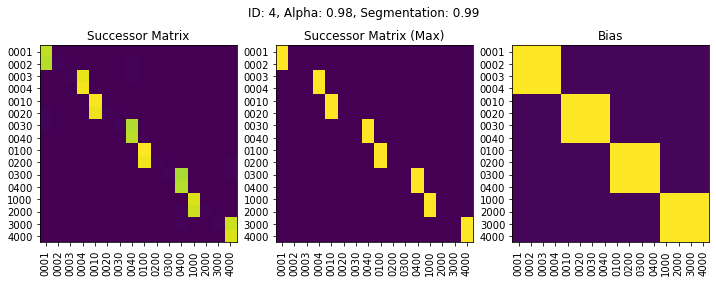

In [44]:
subj = 4
subj_alp = np.round(representations[subj]['agent_info']['alpha'], 2)
subj_seg = np.round(representations[subj]['agent_info']['segmentation'], 2)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(representations[subj]['M'])
axs[0].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[0].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[0].set_title('Successor Matrix')

axs[1].imshow(np.array([row == np.max(row) for row in representations[subj]['M']]))
axs[1].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[1].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[1].set_title('Successor Matrix (Max)')

axs[2].imshow(representations[subj]['bias'], vmin=0, vmax=1)
axs[2].set_xticks(
    np.arange(len(representations[subj]['col_labels'])),
    labels = representations[subj]['col_labels'],
    size = 10,
    rotation = 90
)
axs[2].set_yticks(
    np.arange(len(representations[subj]['row_labels'])),
    labels = representations[subj]['row_labels']
)
axs[2].set_title('Bias')

fig.suptitle(f'ID: {subj}, Alpha: {subj_alp}, Segmentation: {subj_seg}')

np.max(representations[subj]['M'])